In [1]:
%load_ext autoreload
%autoreload 2
import os
from vpower.interp import SimulationParticles
import matplotlib.pyplot as plt
plt.style.use('niceplot2jay.mplstyle')

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
simParticles = SimulationParticles.load_snapshot(SNAPSHOT)

In [2]:
len(simParticles)

9619086

In [2]:
# Bring back Voxelize.
import vpower.voxelize
simField = simParticles.voxelize_interp_to_field(Nsize=256)

Only the CPU-only flavour of Voxelize is available!
Interpolating velocity field...


Padding:  0.035411309549151726 Lbox:  1.0708226190983035 Nsize:  274
Auto padding done. Time elapsed: 12.45 s


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 86407227 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	8.066e+07 exact calculations (R>Rmax),
	5.748e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 86407227 numbers in 2654 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 11.7478 seconds
In the end, 0 in cpu_queue


Interpolation done. Time elapsed: 47.13 s


/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:881: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 0] /= rho_grid
/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:882: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 1] /= rho_grid
/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:883: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 2] /= rho_grid


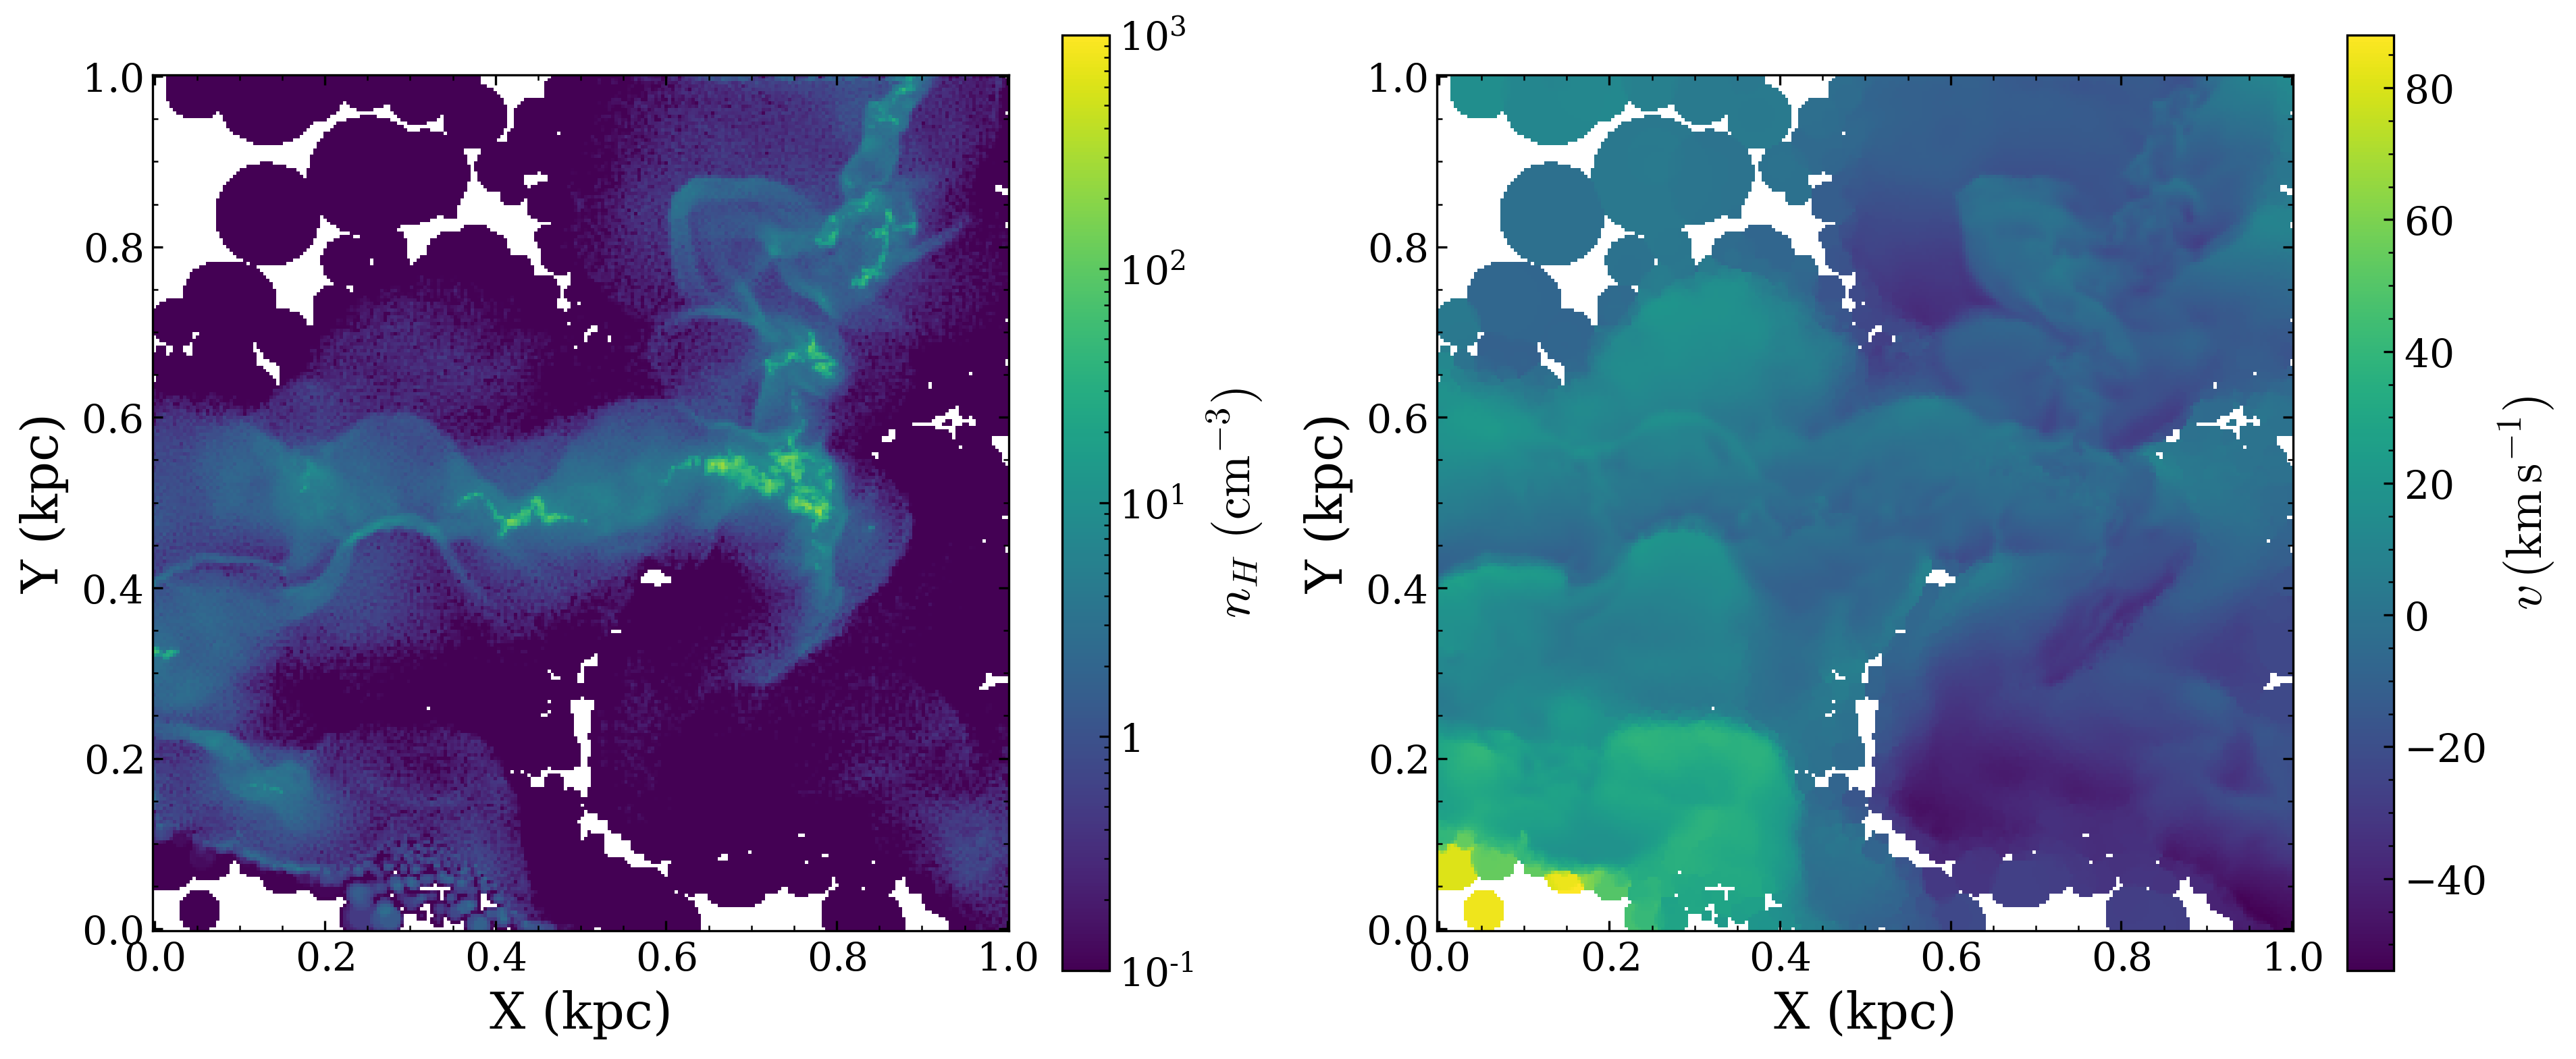

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=128, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=128, axis=2, ax=ax[1])
plt.show()

In [4]:
import numpy as np
simField.vx[np.isnan(simField.vx)] = 0
simField.vy[np.isnan(simField.vy)] = 0
simField.vz[np.isnan(simField.vz)] = 0
np.mean(simField.vx**2), np.mean(simField.vy**2), np.mean(simField.vz**2)

(377.73346, 223.57306, 284.17334)

## Interpolation: Histogram + ANN
To first use histogram to combine the momentum and mass, divide to get velocity in each cell, then use approximate nearest neighbour to fill in the empty cells.

In [7]:
simFieldANN = simParticles.interp_to_field(Nsize=256, eps=0)

Interpolating velocity field...
Box length: 1.0, box size: 256


Histogram deposition done. Time taken: 12.03 s
Data file saved. Time taken: 13.34 s
Query file saved. Time taken: 57.15 s
Approximate Nearest Neighbour complete. Time taken: 64.78 s.



real	1m4.665s
user	1m3.000s
sys	0m1.404s


ANN output read. Time taken: 5.76 s
Interpolation done. Time elapsed: 153.94 s


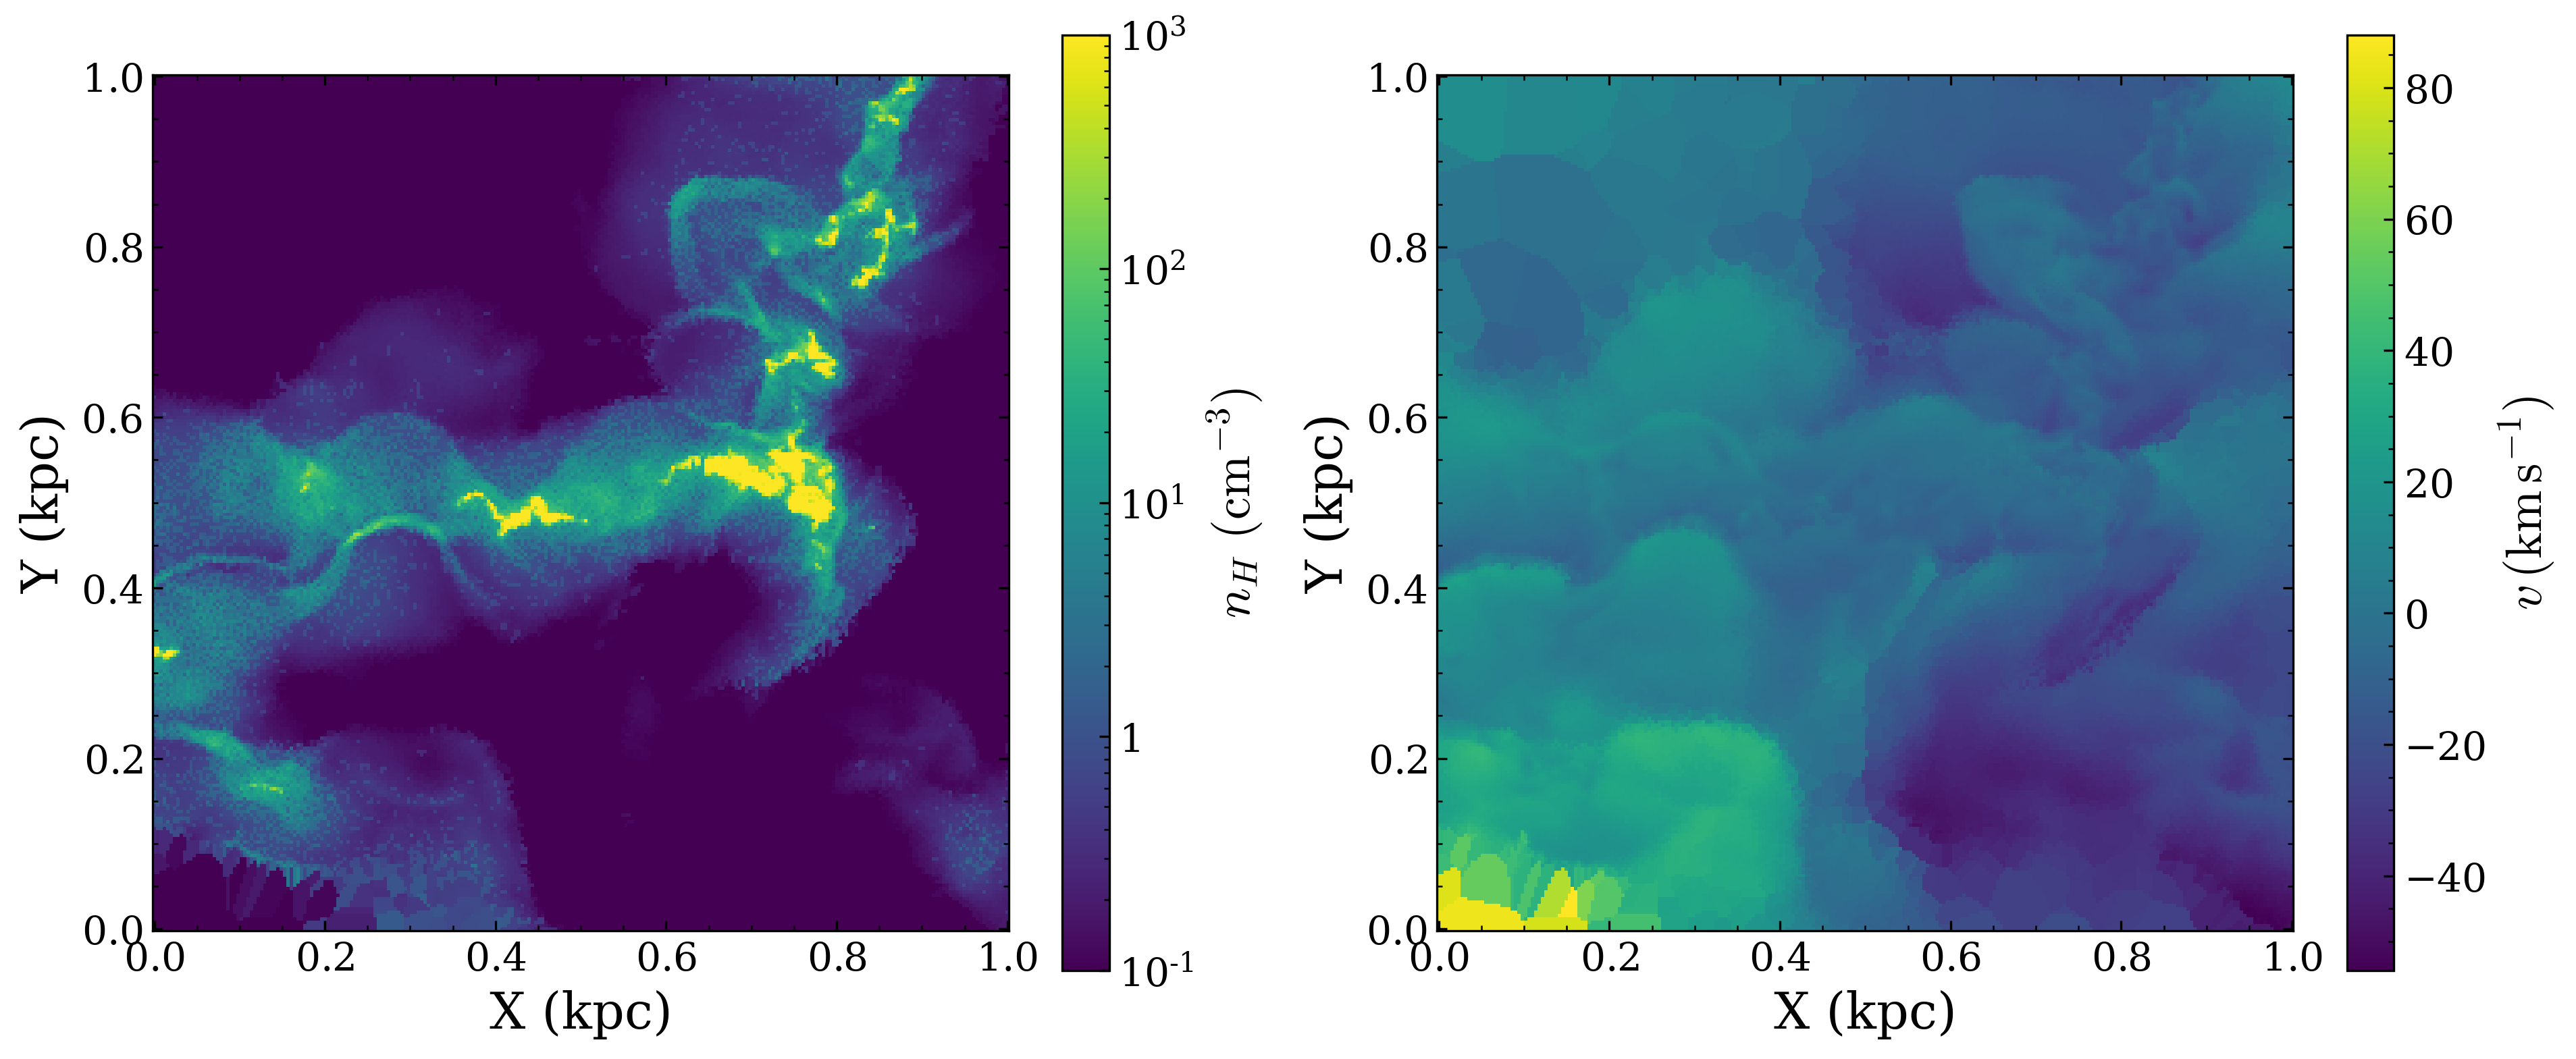

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simFieldANN.plot_density_slice(index=128, axis=2, ax=ax[0])
simFieldANN.plot_velocity_slice(component=0, index=128, axis=2, ax=ax[1])
plt.show()

In [11]:
from vpower.interp import check_conservation
check_conservation(simParticles, simFieldANN)

Total mass of particles: 0.00126
Total mass after interpolation: 3.975e+00


Total momentum of particles: [ 3.32786539e-17 -3.49623437e-16  4.52146187e-18]
Total momentum after interpolation: [-23.71538973   6.23784516  -0.09685445]
Total kinetic energy of particles: 0.305
Total kinetic energy after interpolation: 2.456e+02


In [12]:
import numpy as np
np.mean(simFieldANN.vx**2), np.mean(simFieldANN.vy**2), np.mean(simFieldANN.vz**2)

(419.62027741224983, 244.35774669116677, 320.31092310970456)

## Difference

In [46]:
print("The average difference squared is",
    np.mean((simFieldANN.vx - simField.vx)**2),
    np.mean((simFieldANN.vy - simField.vy)**2),
    np.mean((simFieldANN.vz - simField.vz)**2),
    "for vx, vy, vz, respectively.")

print("If we consider only the region where voxelize is non-zero")
diff_vx = (simFieldANN.vx - simField.vx)
diff_vy = (simFieldANN.vy - simField.vy)
diff_vz = (simFieldANN.vz - simField.vz)

diff_vx[simField.vx == 0] = 0
diff_vy[simField.vy == 0] = 0
diff_vz[simField.vz == 0] = 0

print("vx :", np.mean(diff_vx**2),
      "\nvy :", np.mean(diff_vy**2),
      "\nvz :", np.mean(diff_vz**2))

The average difference squared is 53.56492972355113 28.173495902905767 39.403974388950296 for vx, vy, vz, respectively.
If we consider only the region where voxelize is non-zero
vx : 4.674374993831558 
vy : 3.8344299501827144 
vz : 2.071856561451267


If we plot a slice of the difference


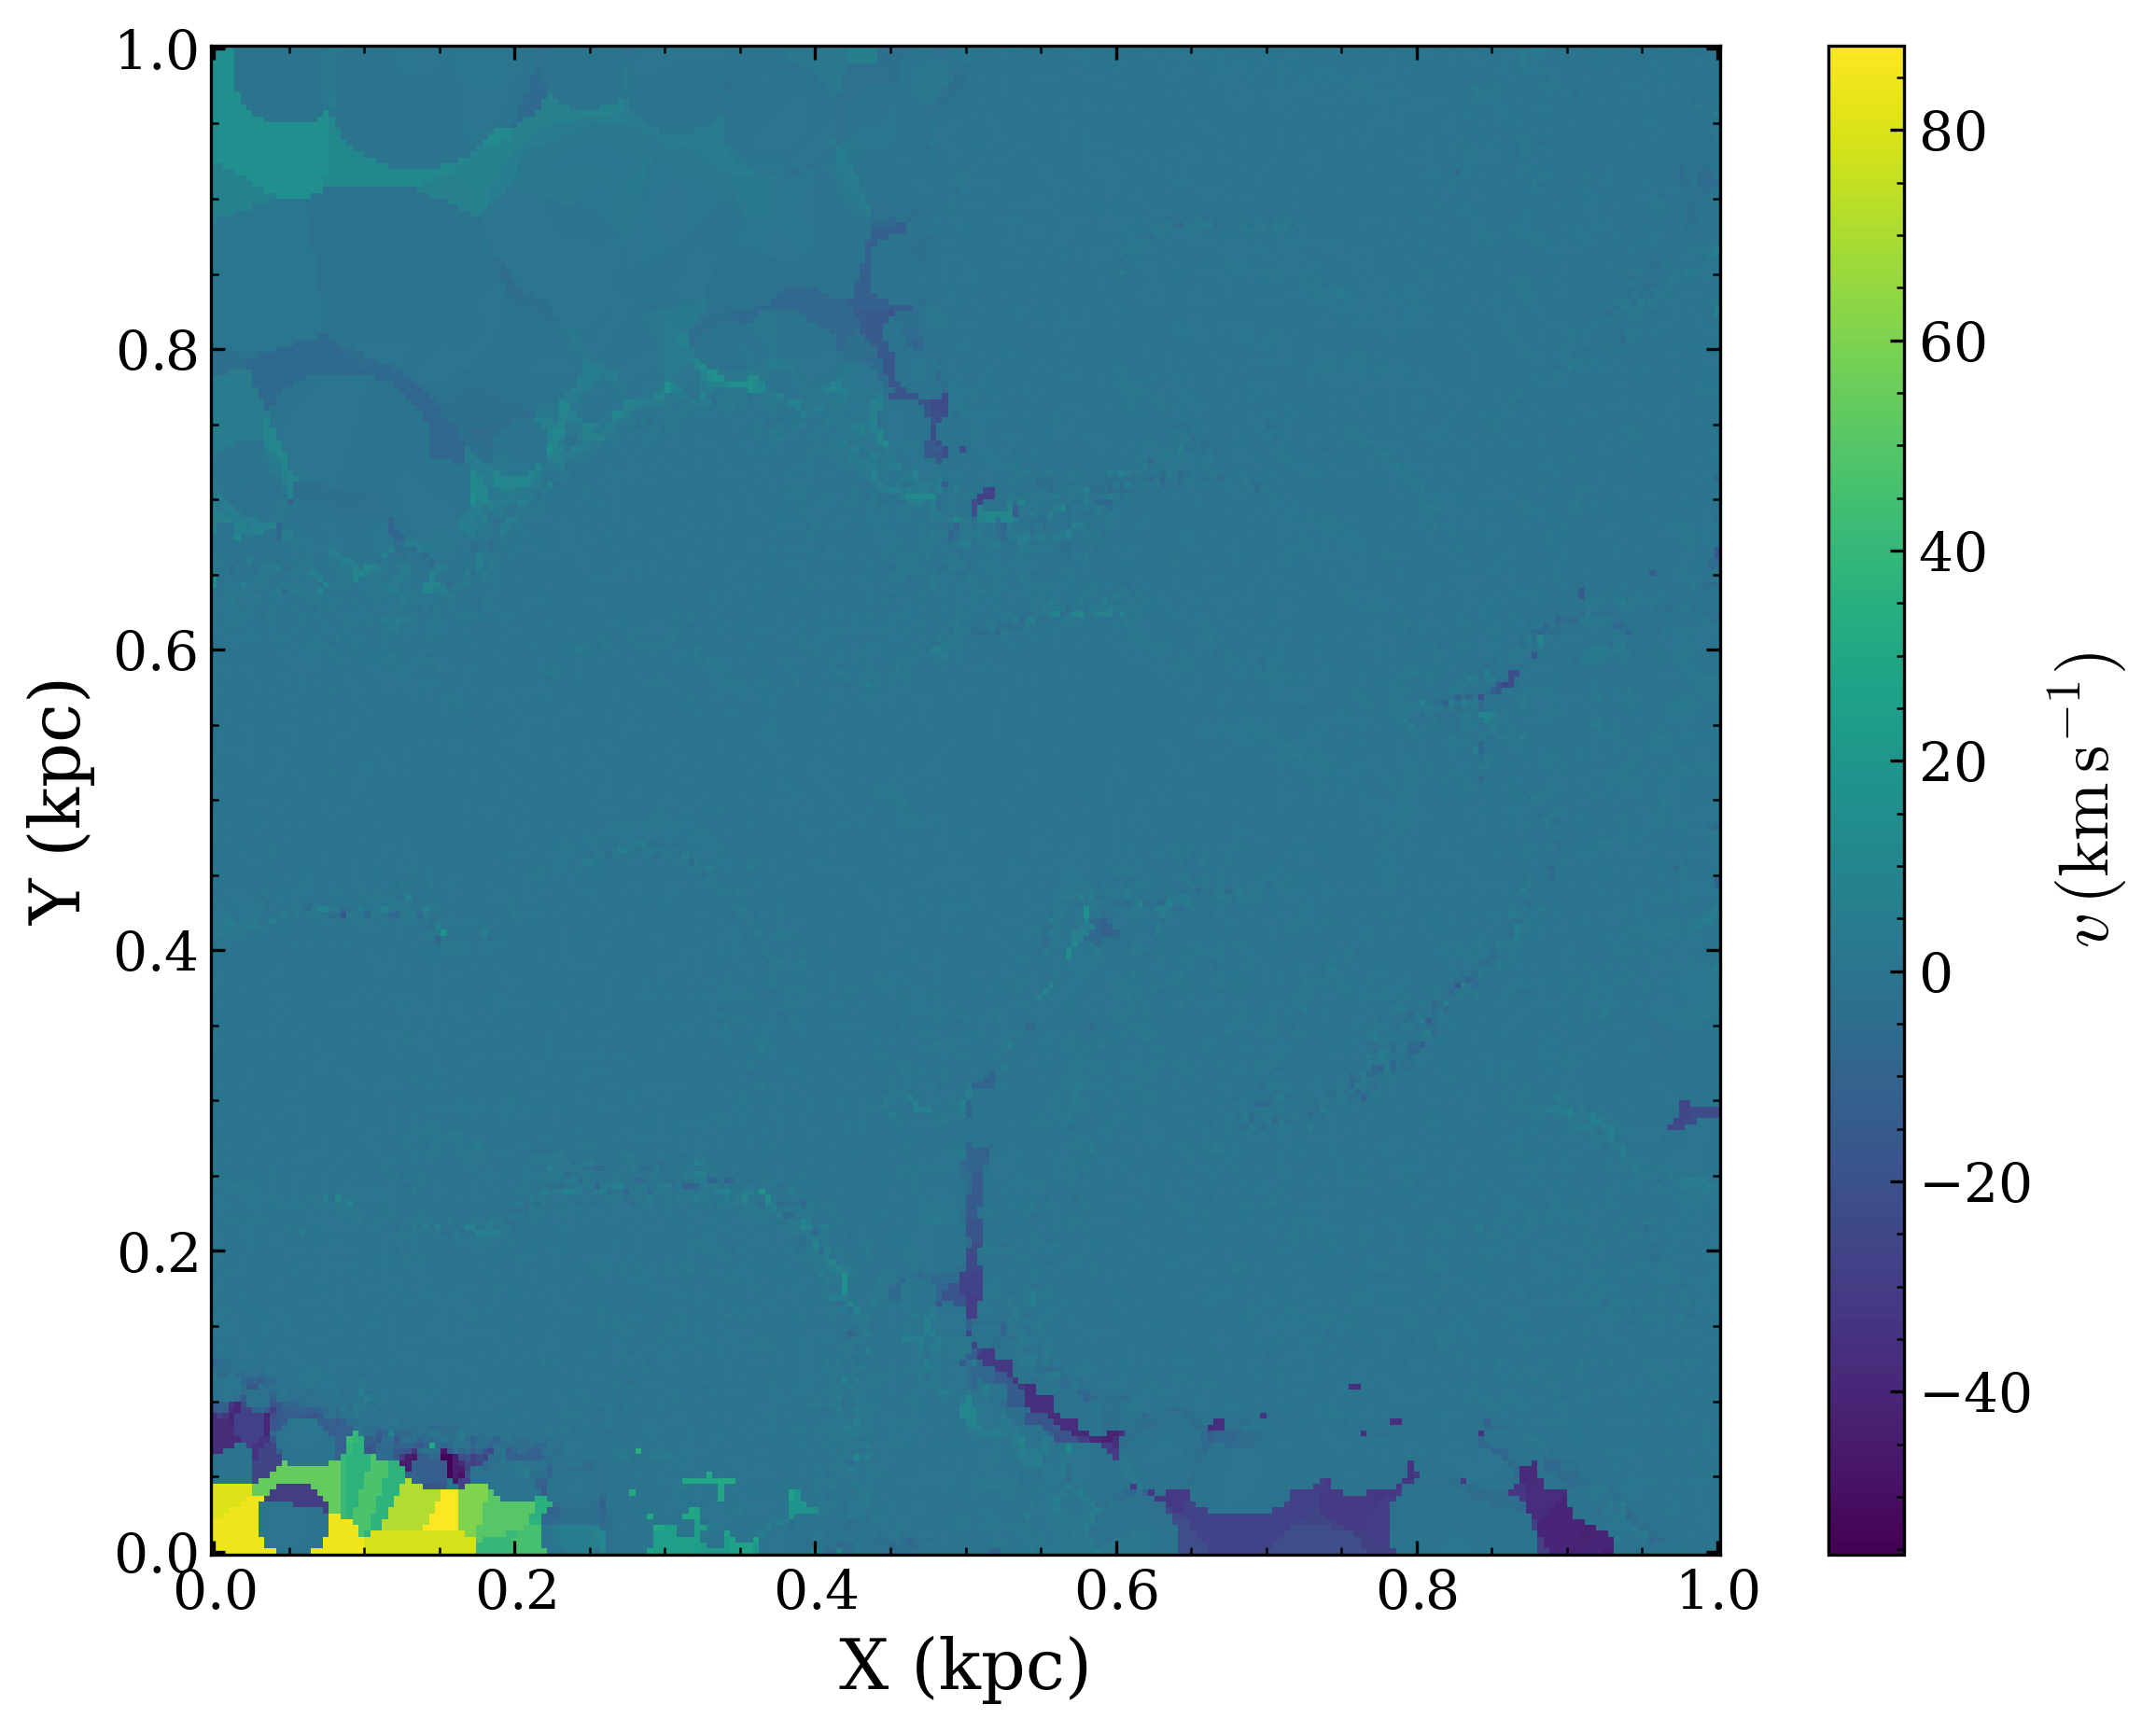

In [38]:
print("If we plot a slice of the difference")
diff_vx = (simFieldANN.vx - simField.vx)
from vpower.interp import plot_velocity2d 
plot_velocity2d(diff_vx[:,:,128], Lbox=1., Nsize=256)
plt.show()

In [44]:
print("If we plot a slice of the difference where voxelize is defined")
diff_vx = np.abs(simFieldANN.vx - simField.vx)
diff_vx[simField.vx == 0] = 0
from vpower.interp import plot_velocity2d 
plot_velocity2d(diff_vx[:,:,128], Lbox=1., Nsize=256)
plt.show()

If we plot a slice of the difference where voxelize is defined


IndexError: index 256 is out of bounds for axis 2 with size 256

## Power Spectra
Check that they produce the same spectrum

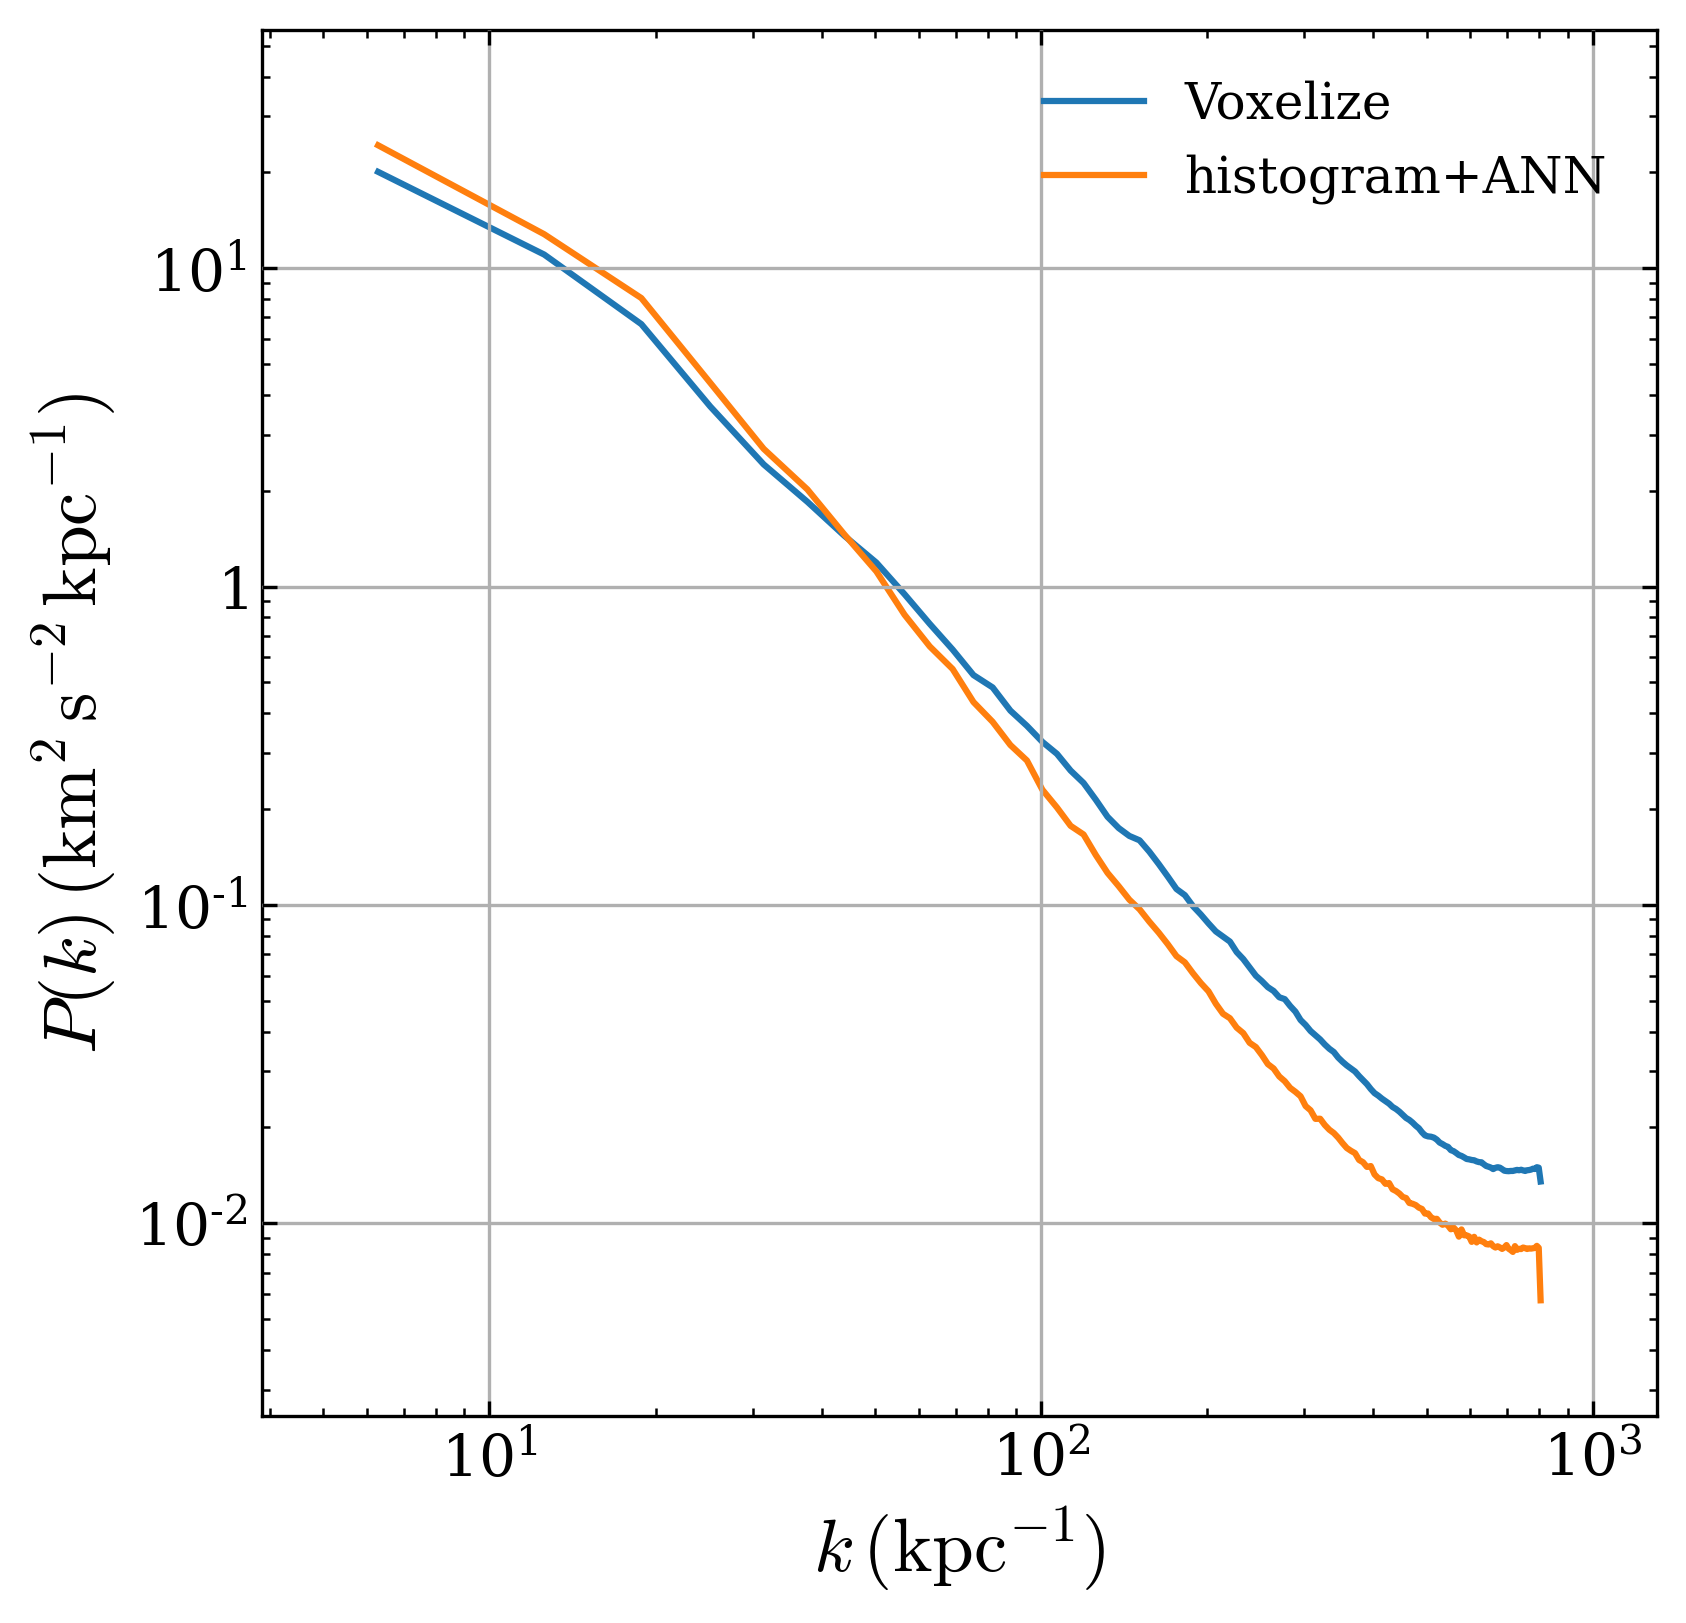

In [ ]:
powerSpctrm = simField.spctrm()
powerSpctrmANN = simFieldANN.spctrm()
fig, ax = plt.subplots(1, 1)
powerSpctrm.plot(ax=ax, label='Voxelize')
powerSpctrmANN.plot(ax=ax, label='histogram+ANN')
plt.legend()
plt.show()

ANN cannot keep mass, momentum, and energy conserved when the resolution is significantly less than the particle scales. Now we test the conservation laws in greater resolution in a small region to see if things can get better. We try up to our target resolution: $\mathrm{Lcell}\sim1/16384=2^{14}$

In [51]:
simParticlesSmall = simParticles[(simParticles.pos[:,0] <= 65/128)
                                 & (simParticles.pos[:,1] <= 65/128)
                                 & (simParticles.pos[:,2] <= 65/128)
                                 & (simParticles.pos[:,0] >= 64/128)
                                 & (simParticles.pos[:,1] >= 64/128)
                                 & (simParticles.pos[:,2] >= 64/128)]
print(len(simParticlesSmall))
simParticlesSmall.Lbox = 1/128
# print(simParticlesSmall.__dict__)

47


In [52]:
simFieldSmall = simParticlesSmall.interp_to_field(Nsize=128, eps=0.2, auto_padding=False)

Interpolating velocity field...
Box length: 0.0078125, box size: 128
Data file saved.


Query file saved.



real	0m5.524s
user	0m5.318s
sys	0m0.093s


Approximate Nearest Neighbour complete. Time taken: 5.54 s.
Interpolation done. Time elapsed: 25.98 s


In [1]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simFieldSmall.plot_density_slice(index=64, axis=2, ax=ax[0], vmin=1, vmax=5)
simFieldSmall.plot_velocity_slice(component=0, index=64, axis=2, ax=ax[1])
plt.show()

NameError: name 'plt' is not defined

In [54]:
from vpower.interp import check_conservation
check_conservation(simParticlesSmall, simFieldSmall)

Total mass of particles: 6.36e-09
Total mass after interpolation: 6.432e-09
Total momentum of particles: [-2.95946953e-08  2.74641483e-08 -3.47089745e-08]
Total momentum after interpolation: [-2.97523670e-08  2.76247544e-08 -3.48986654e-08]
Total kinetic energy of particles: 2.25e-07
Total kinetic energy after interpolation: 2.253e-07


Take Lcell ~ 1/16384, Nsize = 128, Lbox = 1/128. Conservation of mass, momentum, and kinetic energy can hold to 1, 2, and 3 decimal places, respectively.

In [72]:
import numpy as np
np.min(simParticles.h(smoothing_rate=1)), 2**-14
# the radius of the particles is 50 times greater than cell length.

(1.2007644032615404e-06, 1.220703125e-06)

What if we double the size?

In [73]:
simParticlesSmall = simParticles[(simParticles.pos[:,0] <= 65/128)
                                 & (simParticles.pos[:,1] <= 65/128)
                                 & (simParticles.pos[:,2] <= 65/128)
                                 & (simParticles.pos[:,0] >= 63/128)
                                 & (simParticles.pos[:,1] >= 63/128)
                                 & (simParticles.pos[:,2] >= 63/128)]
print(len(simParticlesSmall))
simParticlesSmall.Lbox = 1/128

simFieldSmall = simParticlesSmall.interp_to_field(Nsize=128, eps=0.2, auto_padding=False)

from utils_folding import check_conservation
check_conservation(simParticlesSmall, simFieldSmall)

435
Interpolating velocity field...
Box length: 0.0078125, box size: 128
Data file saved.
Query file saved.



real	0m5.762s
user	0m5.556s
sys	0m0.088s


Approximate Nearest Neighbour complete. Time taken: 5.78 s.
Interpolation done. Time elapsed: 25.99 s
Total mass of particles: 5.9e-08
Total mass after interpolation: 9.058e-09
Total momentum of particles: [-4.10762243e-07  3.04547530e-07 -2.80338817e-07]
Total momentum after interpolation: [-6.50174384e-08  4.90685352e-08 -3.45809675e-08]
Total kinetic energy of particles: 3.06e-06
Total kinetic energy after interpolation: 4.713e-07


## Interpolation to blocks
Next we test the ANN interpolation to blocks.

In [7]:
blocksDecomp = simParticles.interp_to_blocks('output', nblocks=2, Nblock=64,
                                             eps=0.2)

Interpolating velocity field...
Padding complete. Padded box length: 0.6053542127440323, Padded box size: 76
Data file saved.
Query file saved.



real	0m1.144s
user	0m1.112s
sys	0m0.030s


Approximate Nearest Neighbour complete. Time taken: 1.16 s.
Interpolation done. Time elapsed: 5.74 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5745896494457838, Padded box size: 72
Data file saved.
Query file saved.



real	0m1.168s
user	0m1.141s
sys	0m0.025s


Approximate Nearest Neighbour complete. Time taken: 1.18 s.
Interpolation done. Time elapsed: 5.93 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5584916110132099, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.053s
user	0m1.033s
sys	0m0.018s


Approximate Nearest Neighbour complete. Time taken: 1.07 s.
Interpolation done. Time elapsed: 5.08 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5514503827895396, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.065s
user	0m1.043s
sys	0m0.020s


Approximate Nearest Neighbour complete. Time taken: 1.08 s.
Interpolation done. Time elapsed: 5.05 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5673430751500064, Padded box size: 72
Data file saved.
Query file saved.



real	0m1.035s
user	0m1.014s
sys	0m0.019s


Approximate Nearest Neighbour complete. Time taken: 1.05 s.
Interpolation done. Time elapsed: 5.27 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5860245595575861, Padded box size: 74
Data file saved.
Query file saved.



real	0m0.959s
user	0m0.936s
sys	0m0.020s


Approximate Nearest Neighbour complete. Time taken: 0.97 s.
Interpolation done. Time elapsed: 4.78 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5620610057727617, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.190s
user	0m1.171s
sys	0m0.016s


Approximate Nearest Neighbour complete. Time taken: 1.21 s.
Interpolation done. Time elapsed: 7.29 s
Interpolating velocity field...
Padding complete. Padded box length: 0.6145388713159718, Padded box size: 78
Data file saved.
Query file saved.



real	0m1.135s
user	0m1.105s
sys	0m0.028s


Approximate Nearest Neighbour complete. Time taken: 1.15 s.
Interpolation done. Time elapsed: 6.30 s


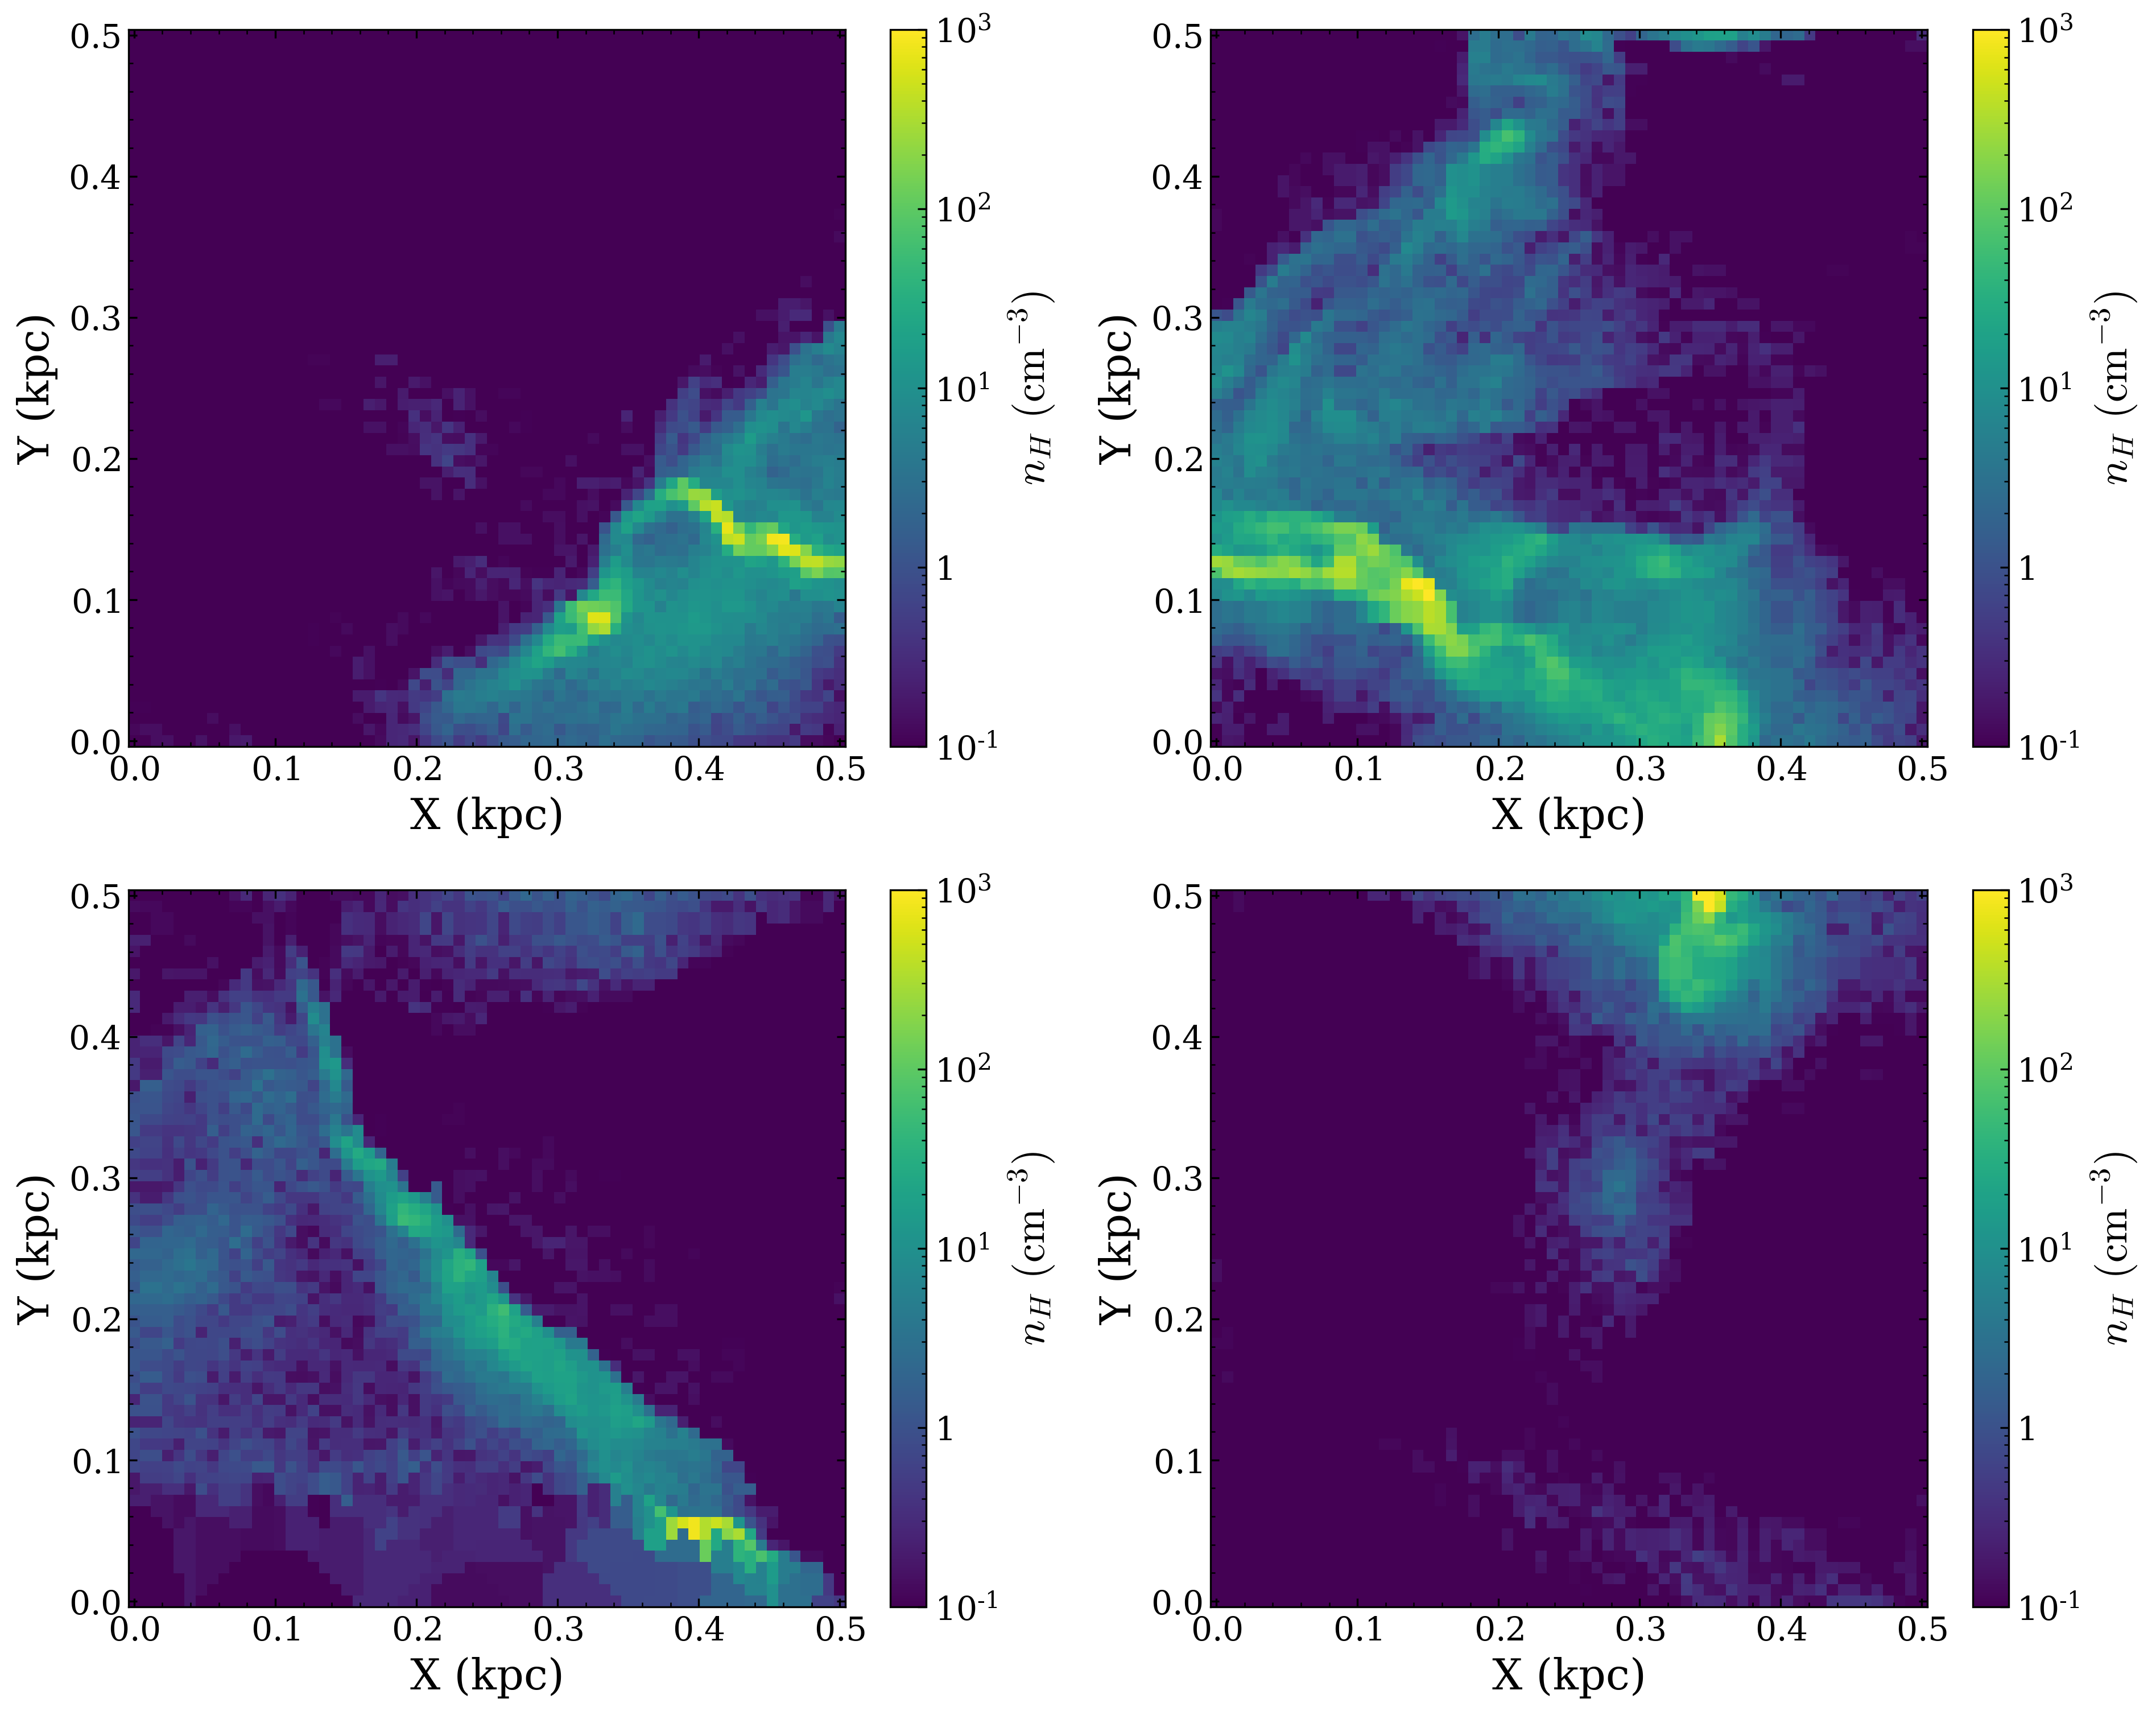

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
blocksDecomp[0,0,0].plot_density_slice(index=32, axis=2, ax=ax[1,0])
blocksDecomp[1,0,0].plot_density_slice(index=32, axis=2, ax=ax[0,0])
blocksDecomp[0,1,0].plot_density_slice(index=32, axis=2, ax=ax[1,1])
blocksDecomp[1,1,0].plot_density_slice(index=32, axis=2, ax=ax[0,1])
plt.show()

In [30]:
simField = simParticles.interp_to_field(Nsize=128, eps=0.2)

Interpolating velocity field...
Box length: 1.0, box size: 128


Data file saved.
Query file saved.



real	0m8.647s
user	0m8.374s
sys	0m0.148s


Approximate Nearest Neighbour complete. Time taken: 8.69 s.
Interpolation done. Time elapsed: 41.41 s


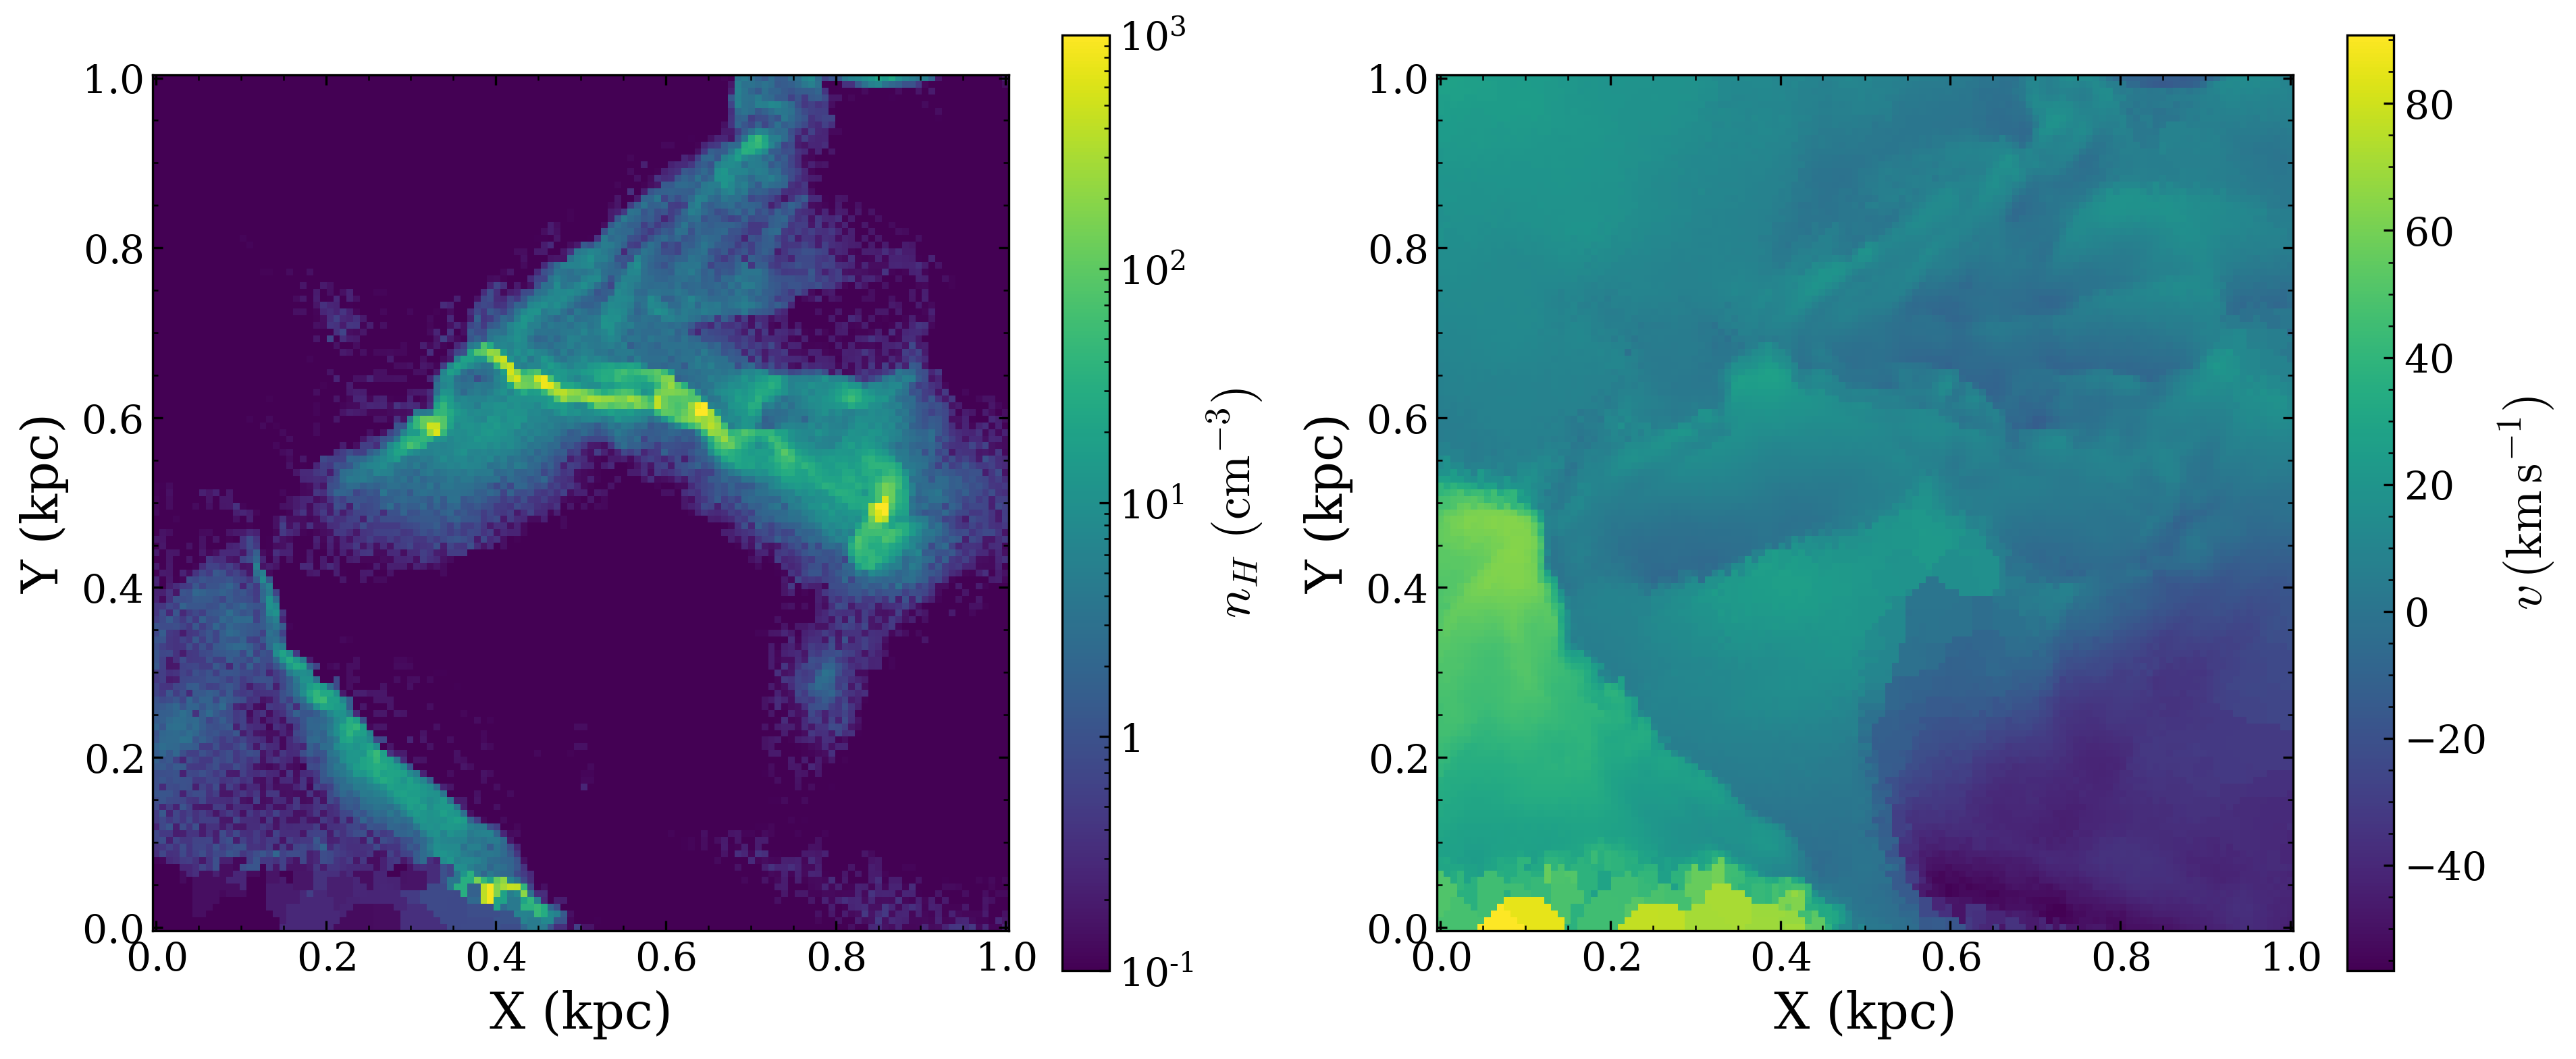

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=32, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=32, axis=2, ax=ax[1])
plt.show()